<a href="https://colab.research.google.com/github/abtheo/BrainReadWrite/blob/master/Phosphene_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Reading & Writing: Phosphene Vision

---



In [ ]:
from scipy import signal # for 2D convolution
import scipy
from skimage import filters
import matplotlib.pyplot as plt # for general plotting
import numpy as np              # for everything else

In [ ]:
electrode_size = 32  # number of electrodes
pixel_size     = 512 # number of pixels
phosphene_size = 3   # standard deviation

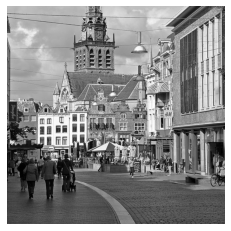

In [ ]:
def get_example_pixel_image(pixel_size):
    from PIL import Image
    from os import system
    system("wget -O pixel_image.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Nijmegen_Stevenskerk_R10.jpg/559px-Nijmegen_Stevenskerk_R10.jpg")
    pixel_image = Image.open("pixel_image.jpg")
    pixel_image = np.array(pixel_image.crop((0, pixel_image.height - pixel_image.width, pixel_image.width, pixel_image.height)).resize((pixel_size, pixel_size), Image.LANCZOS).convert("L"))
    _ = plt.imshow(pixel_image, cmap="gray")
    _ = plt.axis("off")
    return pixel_image

pixel_image = get_example_pixel_image(pixel_size)

We want to implement a phosphene vision simulator, which is basically a function that gets a (preprocessed) pixel image as input and gives a phosphene image as output:

1.   Creating an electrode grid
2.   Creating an electrode image
3.   Creating a phosphene filter
4.   Creating a phosphene image


In [ ]:
"""
Generates a 'mask' for a given square image.
Masks allow selective indexing upon N-dimensional arrays,
in this case a 2D matrix representing image pixels.

By applying a boolean mask, we can select only the indexes of a given matrix
which match a certain condition.

Here, we wish to select only the pixel indexes at certain tick intervals,
corresponding with the limited resolution of the electrodes.
"""
def create_electrode_grid(electrode_size, pixel_size):
  #Initialise square numpy matrix
  electrode_grid = np.zeros((pixel_size, pixel_size), "bool")
  #Define iterable steps, corresponding to the pixel location of each electrode
  ticks = np.linspace(0, pixel_size - 1, electrode_size).astype("uint16")
  #Generate the 'mask' 
  # - Boolean mapping for matrix index selection
  for tick in ticks:
      electrode_grid[tick, ticks] = True
  return electrode_grid

electrode_grid = create_electrode_grid(electrode_size, pixel_size)

The electrode grid should be multiplied with the pixel image and thresholded to transform continious pixel lumininces to binary electrode activations. This operation can be thresholded to different levels, altering the percieved sensitivity of the electrodes.

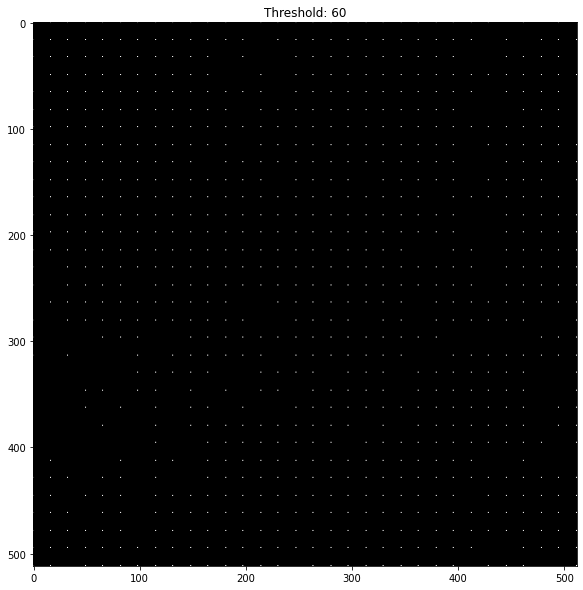

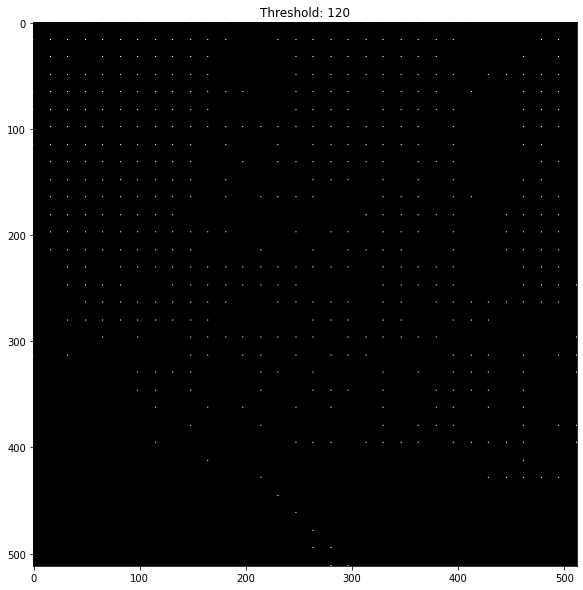

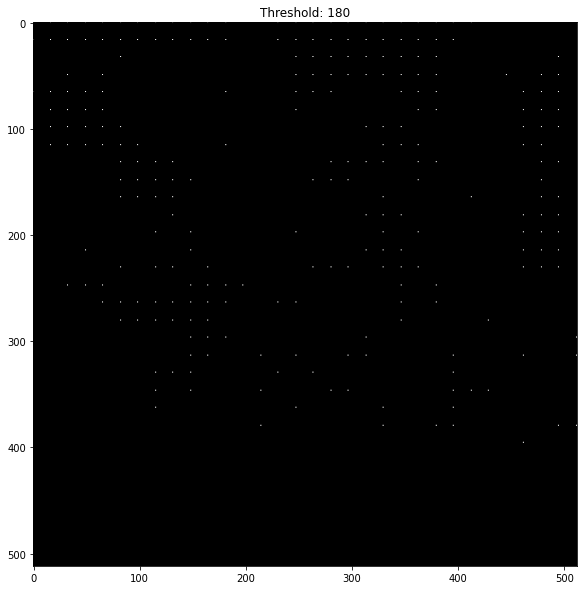

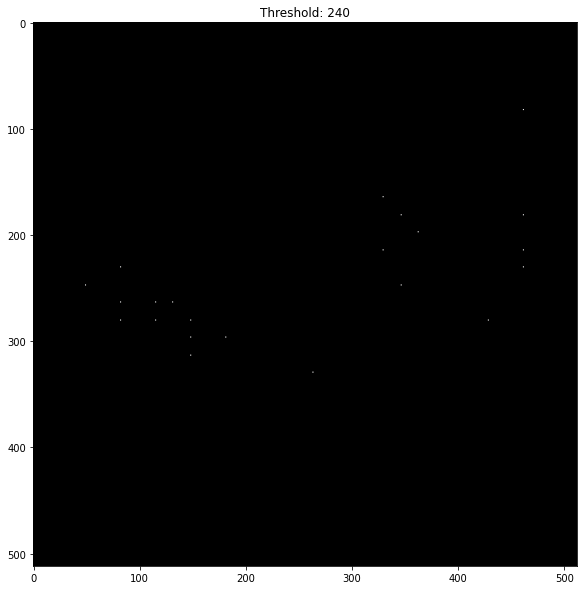

In [ ]:
def create_electrode_image(electrode_grid, pixel_image, threshold):
    #Apply mask, setting any value outside of the electrode_grid to 0.
    electrode_image = pixel_image.copy() * electrode_grid
    #Threshold using parameter into binary activations
    electrode_image[electrode_image >= threshold] = 255
    electrode_image[electrode_image < threshold] = 0
    
    return electrode_image

electrode_image = create_electrode_image(electrode_grid, pixel_image, 120) 

#Plot a few examples with different thresholds:
#The higher the threshold, 
#the brighter the image pixel must be to activate the electrode.
for i in range(1,5):
  thresh = 60 * i
  plt.figure(figsize=(10,10))
  plt.imshow(create_electrode_image(electrode_grid, pixel_image, thresh),cmap='binary_r')
  plt.title(f"Threshold: {thresh}")
  plt.show()

# Gaussian Blobs

---



What we have so far can already be used as a phosphene vision simulator, if you assume phosphenes are individual pixels. However, this assumption is not valid. A better assumption is that phosphenes are Gaussian blobs.

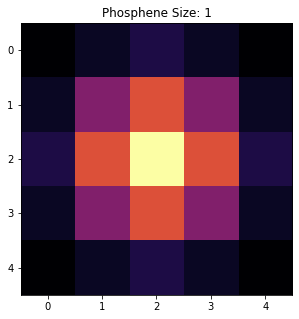

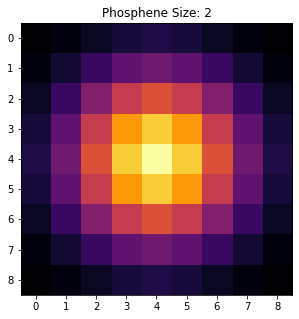

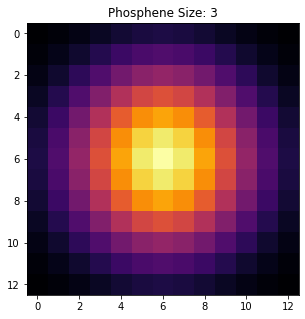

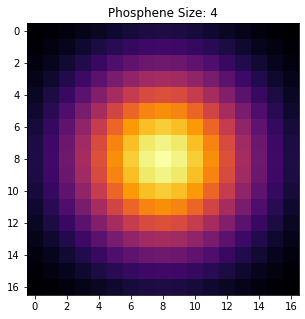

In [ ]:
def create_phosphene_filter(phosphene_size):
    temp = np.arange(-np.ceil(2 * phosphene_size), np.ceil(2 * phosphene_size) + 1)
    x, y = np.meshgrid(temp, temp)

    #Taking phosphene_size to be both the filter area and the standard deviation sigma value.
    phosphene_filter = np.exp(-0.5 * (np.square(x) + np.square(y)) / np.square(phosphene_size))

    return phosphene_filter

#Large enough value causes phosphenes to overlap and self-interact.
#Looks super cool, but not sure if this is realistic?
phosphene_filter = create_phosphene_filter(7)

#Plot a few examples with different sizes:
for i in range(1,5):
  plt.figure(figsize=(5,5))
  plt.imshow(create_phosphene_filter(i), cmap='inferno')
  plt.title(f"Phosphene Size: {i}")
  plt.show()


Electrode images can be transformed to phosphene images by convolving them with a phosphene filter. Implement the following function to perform this operation, test it on the electrode images and the phosphene filter that you have created, and plot the outputs.

    def create_phosphene_image(electrode_image, phosphene_filter):
        # phosphene_image = ...
        return phosphene_image

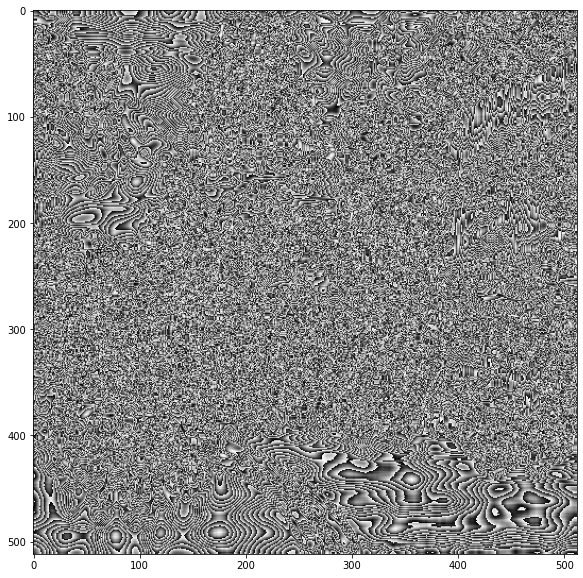

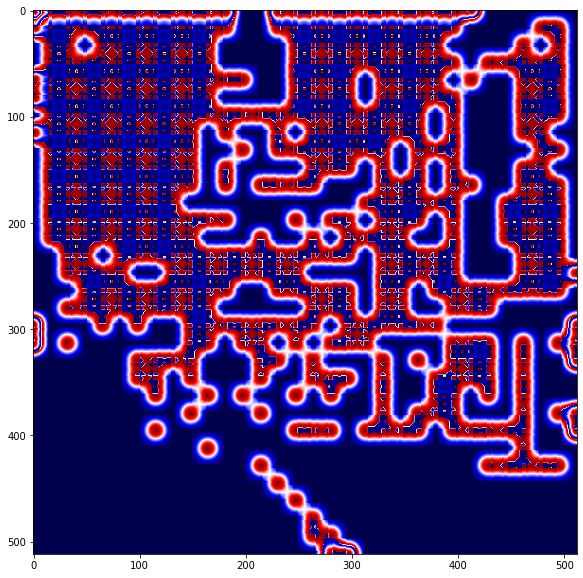

In [ ]:
def create_phosphene_image(electrode_image, phosphene_filter):
    #Everywhere the image is non-zero,
    #Apply the kernel / phosphene_filter.
    #Too much of a pain to implement manually because of edge padding.
    return scipy.ndimage.filters.convolve(electrode_image, phosphene_filter)

#Plot the Phosphene Image, from the Pixel Image + Phosphene Filter
plt.figure(figsize=(10,10))
plt.imshow(create_phosphene_image(pixel_image, phosphene_filter), cmap='gray')
plt.show()
#Plot the Phosphene Image, from the Electrode Image + Phosphene Filter
plt.figure(figsize=(10,10))
plt.imshow(create_phosphene_image(electrode_image, phosphene_filter), cmap='seismic')
plt.show()

As you can see, it is not very helpful to directly use pixel images for phosphene vision. The main challenge is to find more helpful representations of pixel images and use them for phosphene vision. We can take pixel images and apply different filters and use the phosphene vision simulator that we have implemented to explore how helpful different representations of pixel images are for phosphene vision. 

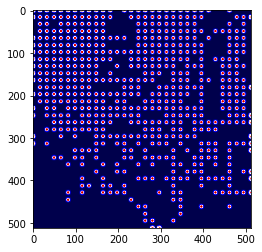

In [ ]:
def pixel_to_phosphene(pixel_image, phosphene_size, threshold):
  electrode_grid = create_electrode_grid(electrode_size, pixel_size)
  electrode_image = create_electrode_image(electrode_grid, pixel_image, threshold)
  phosphene_filter = create_phosphene_filter(phosphene_size)
  return create_phosphene_image(electrode_image, phosphene_filter)

plt.imshow(pixel_to_phosphene(pixel_image,3,100),cmap='seismic')
plt.show()

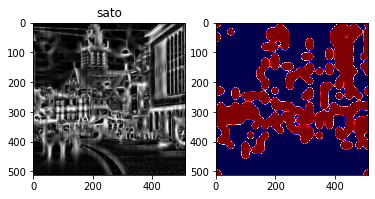

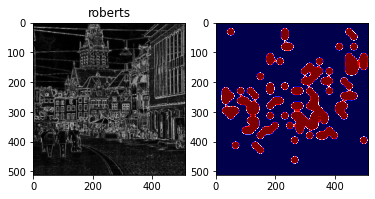

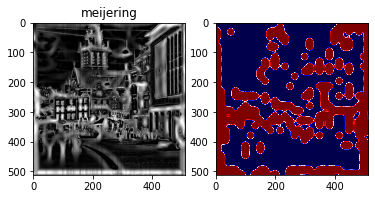

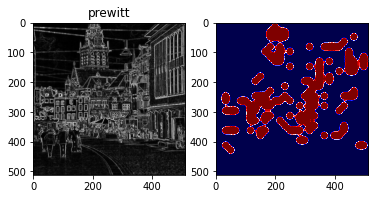

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#SKImage Filters each return some arbitrary ranges,
#Scale back to [0,255] for plotting and thresholding. 
image_scaler = MinMaxScaler(feature_range=(0,255))
filtered_images = { "sato" : image_scaler.fit_transform(filters.sato(pixel_image)),
                   "roberts" : image_scaler.fit_transform(filters.roberts(pixel_image)),
                   "meijering" : image_scaler.fit_transform(filters.meijering(pixel_image)),
                   "prewitt" : image_scaler.fit_transform(filters.prewitt(pixel_image))
                  }


for filter_name, image in filtered_images.items():
  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.imshow(image,cmap='gray')
  phosphene_image = pixel_to_phosphene(image,9,100)
  phosphene_image = create_electrode_image(np.ones_like(phosphene_image),phosphene_image,100)
  ax2.imshow(phosphene_image,cmap='seismic')
  ax1.set_title(filter_name)

plt.show()
